## Tutorial de implementación de DeepDream

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib as plt

import IPython.display as display
import PIL.Image

#### Selección de una imagen

In [10]:
# URL para descargar la imagen (calabaza de Halloween)
url = 'https://eckerts.com/app/uploads/2021/08/Jack-o-27-Lantern-300x2661-2.jpg'

# Descargar y convertirla en un array
def download(url, max_dim=None):
    name = url.split('/')[-1] # Seleccionar el nombre (final de la URL)
    img_path = tf.keras.utils.get_file(name, origin=url) # Cargar el path
    img = PIL.Image.open(img_path) # Cargar la imagen desde el path
    if max_dim:
        img.thumbnail((max_dim, max_dim)) # Redimensiona la imagen limitando el tamaño
    return np.array(img)

# Normalizar
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

# Mostrar la imagen
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


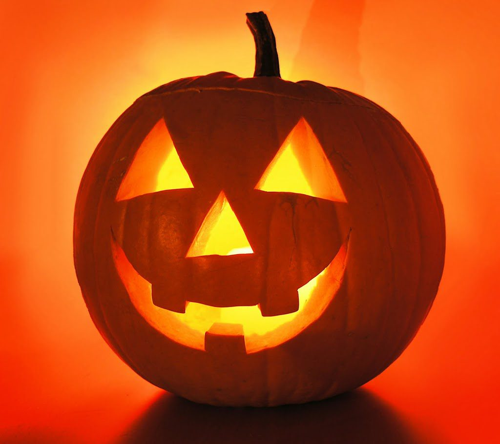

In [11]:
# Reducir las dimensiones facilita el trabajo
original_img = download(url, max_dim=500)
display.display(display.HTML("Jack O'Lantern"))
show(original_img)

#### Preparar modelo de extracción de características (InceptionV3)  
La idea en DeepDream es elegir una capa (o capas) y maximizar la "pérdida" de manera que la imagen "excite" cada vez más las capas. Las capas inferiores producen trazos o patrones simples, mientras que las capas más profundas brindan características sofisticadas en las imágenes

In [12]:
# Quita el top permite añadir capas personalizadas al final / Carga los pesos preentrenados del dataset ImageNet
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
# Maximizar la activación de estas capas
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Crear el modelo de extracción de características
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

#### Calcular pérdida
La pérdida es la suma de las activaciones en las capas elegidas. La pérdida se normaliza en cada capa para que la contribución de las capas más grandes no supere a las capas más pequeñas. Normalmente, la pérdida es una cantidad que desea minimizar a través del descenso de gradiente. En DeepDream, al contrario, se maximizará esta pérdida a través del ascenso de gradiente.

In [ ]:
# Avanza la imagen a lo largo del modelo para recuperar las activaciones
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0) #Convierte la imagen en un batch de tamaño 1
    layer_activations = model(img_batch) # Produce un tensor con las activaciones de la capa
    if len(layer_activations) == 1:
        layer_activations = [layer_activations] # Asegura que las activaciones de la capa son una lista
    
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act) # Calcula la media de todas las activaciones
        losses.append(loss)
    
    return tf.reduce_sum(losses)
